In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gender_guesser.detector import Detector
detector = Detector()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay
)

# Classification models (Unit II)
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Ensemble (Unit III)
from sklearn.ensemble import RandomForestClassifier

In [160]:
def read_datasets():
    genuine = pd.read_csv("users.csv")
    fake = pd.read_csv("fusers.csv")

    genuine["label"] = 1
    fake["label"] = 0

    df = pd.concat([genuine, fake], ignore_index=True)
    return genuine, fake, df


In [161]:
genuine, fake, df = read_datasets()


In [162]:
print(genuine.head())

        id              name screen_name  statuses_count  followers_count  \
0  3610511  Davide Dellacasa      braddd           20370             5470   
1  5656162    Simone Economo       eKoeS            3131              506   
2  5682702            tacone     tacone_            4024              264   
3  6067292          alesaura    alesstar           40586              640   
4  6015122            Angelo  PerDiletto            2016               62   

   friends_count  favourites_count  listed_count  \
0           2385               145            52   
1            381                 9            40   
2             87               323            16   
3            622              1118            32   
4             64                13             0   

                       created_at                                url  ...  \
0  Fri Apr 06 10:58:22 +0000 2007           http://braddd.tumblr.com  ...   
1  Mon Apr 30 15:08:42 +0000 2007         http://www.lineheight.net/  

In [163]:
print(genuine.isnull().sum())

id                                       0
name                                     0
screen_name                              0
statuses_count                           0
followers_count                          0
friends_count                            0
favourites_count                         0
listed_count                             0
created_at                               0
url                                   1018
lang                                     0
time_zone                              418
location                               492
default_profile                       1084
default_profile_image                 1477
geo_enabled                            762
profile_image_url                        0
profile_banner_url                     496
profile_use_background_image            58
profile_background_image_url_https       0
profile_text_color                       0
profile_image_url_https                  0
profile_sidebar_border_color             0
profile_bac

In [164]:
print(fake.head())

          id                name   screen_name  statuses_count  \
0  370098498        pirfectmoses  pirfectmoses              24   
1   37384589            SAK Nair   bsknair1967             656   
2   72110028              Deepak       dedjven            1234   
3   82885728     Marcos Vinicius     BrowAlves             573   
4  110120789  Shri Kant Kanaujia    kanaujiask             675   

   followers_count  friends_count  favourites_count  listed_count  \
0                4            588                16             0   
1               57            693               597             0   
2               15            104              1150             0   
3               14            227               530             0   
4               18            519               653             0   

                       created_at  url  ...  \
0  Thu Sep 08 13:20:35 +0000 2011  NaN  ...   
1  Sun May 03 07:35:13 +0000 2009  NaN  ...   
2  Sun Sep 06 19:50:08 +0000 2009  NaN  ...   


In [165]:
print(fake.isnull().sum())

id                                       0
name                                     0
screen_name                              0
statuses_count                           0
followers_count                          0
friends_count                            0
favourites_count                         0
listed_count                             0
created_at                               0
url                                   1337
lang                                     0
time_zone                             1331
location                                55
default_profile                          6
default_profile_image                 1333
geo_enabled                           1335
profile_image_url                        0
profile_banner_url                    1335
profile_use_background_image             0
profile_background_image_url_https       0
profile_text_color                       0
profile_image_url_https                  0
profile_sidebar_border_color             0
profile_bac

In [166]:
print(df.head())

        id              name screen_name  statuses_count  followers_count  \
0  3610511  Davide Dellacasa      braddd           20370             5470   
1  5656162    Simone Economo       eKoeS            3131              506   
2  5682702            tacone     tacone_            4024              264   
3  6067292          alesaura    alesstar           40586              640   
4  6015122            Angelo  PerDiletto            2016               62   

   friends_count  favourites_count  listed_count  \
0           2385               145            52   
1            381                 9            40   
2             87               323            16   
3            622              1118            32   
4             64                13             0   

                       created_at                                url  ...  \
0  Fri Apr 06 10:58:22 +0000 2007           http://braddd.tumblr.com  ...   
1  Mon Apr 30 15:08:42 +0000 2007         http://www.lineheight.net/  

In [167]:
print(df.isnull().sum())

id                                       0
name                                     0
screen_name                              0
statuses_count                           0
followers_count                          0
friends_count                            0
favourites_count                         0
listed_count                             0
created_at                               0
url                                   2355
lang                                     0
time_zone                             1749
location                               547
default_profile                       1090
default_profile_image                 2810
geo_enabled                           2097
profile_image_url                        0
profile_banner_url                    1831
profile_use_background_image            58
profile_background_image_url_https       0
profile_text_color                       0
profile_image_url_https                  0
profile_sidebar_border_color             0
profile_bac

In [168]:
def predict_sex(name_series):

    def get_code(name):
        n = name.split(" ")[0]
        gender = detector.get_gender(n)

        mapping = {
            'female': -2,
            'mostly_female': -1,
            'andy': 0,
            'unknown': 0,
            'mostly_male': 1,
            'male': 2
        }
        return mapping.get(gender, 0)

    return name_series.astype(str).apply(get_code)

In [169]:
sex_codes = predict_sex(df["name"])
print(sex_codes.head())


0    2
1   -2
2    0
3    0
4    2
Name: name, dtype: int64


In [170]:
def extract_features(df):
    df = df.copy()
    le = LabelEncoder()
    df["lang_code"]=le.fit_transform(df["lang"].astype(str))  #encoding lang

    df["sex_code"]=predict_sex(df["name"])
    feature_cols = [
        "statuses_count", "followers_count", "friends_count",
        "favourites_count", "listed_count", "sex_code", "lang_code"
    ]

    X = df[feature_cols]
    y = df["label"]

    return X, y



In [171]:
X,y=extract_features(df)
print(X)

      statuses_count  followers_count  friends_count  favourites_count  \
0              20370             5470           2385               145   
1               3131              506            381                 9   
2               4024              264             87               323   
3              40586              640            622              1118   
4               2016               62             64                13   
...              ...              ...            ...               ...   
2813               1                0             17                 0   
2814               0                1             17                 0   
2815               2                0             15                 0   
2816               2                0             16                 0   
2817               0                0             17                 0   

      listed_count  sex_code  lang_code  
0               52         2          5  
1               40        -

In [172]:
print("X shape:", X.shape)

X shape: (2818, 7)


In [173]:
print("y shape:", y.shape)

y shape: (2818,)


In [174]:
print(y)

0       1
1       1
2       1
3       1
4       1
       ..
2813    0
2814    0
2815    0
2816    0
2817    0
Name: label, Length: 2818, dtype: int64


In [175]:
def preprocess(X, y):
    X = X.fillna(X.median())  # handle missing values

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    return X,x_train, x_test,x_train_scaled,x_test_scaled, y_train, y_test

In [176]:
X, x_train, x_test, x_train_scaled, x_test_scaled, y_train, y_test = preprocess(X, y)


In [177]:
print(X)

      statuses_count  followers_count  friends_count  favourites_count  \
0              20370             5470           2385               145   
1               3131              506            381                 9   
2               4024              264             87               323   
3              40586              640            622              1118   
4               2016               62             64                13   
...              ...              ...            ...               ...   
2813               1                0             17                 0   
2814               0                1             17                 0   
2815               2                0             15                 0   
2816               2                0             16                 0   
2817               0                0             17                 0   

      listed_count  sex_code  lang_code  
0               52         2          5  
1               40        -

In [178]:
print(f"Training data:\n {x_train.head()}")

Training data:
       statuses_count  followers_count  friends_count  favourites_count  \
2243              23               19            310                 0   
2189              32               16            316                 0   
2709               3                1             42                 0   
2603              35               12            301                 0   
1027            1095               45             52                 2   

      listed_count  sex_code  lang_code  
2243             0        -2          1  
2189             0         0          1  
2709             0        -2          1  
2603             0         2          1  
1027             0        -2          5  


In [179]:
print("x_train:", x_train.shape)

x_train: (2254, 7)


In [180]:
  print(f"Testing data:\n {x_test.head()}")

Testing data:
       statuses_count  followers_count  friends_count  favourites_count  \
2562              18               12            255                 0   
1789              69               22            617                 0   
1427             951               47            123                38   
741              506              106            168                 6   
1103             190               12             41                12   

      listed_count  sex_code  lang_code  
2562             0         2          1  
1789             0        -2          1  
1427             1        -2          5  
741              0         2          5  
1103             0         0          5  


In [181]:
print("x_test:", x_test.shape)

x_test: (564, 7)


In [182]:
print(f"Training labels:\n {y_train.head()}")

Training labels:
 2243    0
2189    0
2709    0
2603    0
1027    1
Name: label, dtype: int64


In [183]:
print("y_train:", y_train.shape)

y_train: (2254,)


In [184]:
print(f"Testing labels:\n {y_test.head()}")

Testing labels:
 2562    0
1789    0
1427    1
741     1
1103    1
Name: label, dtype: int64


In [185]:
print("y_test:", y_test.shape)

y_test: (564,)


In [186]:
print(x_train_scaled)

[[-0.33935287 -0.08233545 -0.18010113 ... -0.12411434 -1.1096611
  -0.917284  ]
 [-0.33742226 -0.08355244 -0.16749079 ... -0.12411434  0.12366046
  -0.917284  ]
 [-0.34364309 -0.08963738 -0.74336309 ... -0.12411434 -1.1096611
  -0.917284  ]
 ...
 [-0.19670286 -0.07016558 -0.44071487 ... -0.12411434  0.12366046
   1.09151671]
 [ 1.17359527  0.06654269  0.71523319 ... -0.07477506  0.12366046
   1.09151671]
 [-0.09609706 -0.02189174 -0.46383383 ... -0.07477506 -1.1096611
   1.09151671]]


In [187]:
print(x_test_scaled)

[[-0.34042542 -0.08517509 -0.29569593 ... -0.12411434  1.35698201
  -0.917284  ]
 [-0.32948535 -0.08111847  0.46512806 ... -0.12411434 -1.1096611
  -0.917284  ]
 [-0.14028639 -0.0709769  -0.57312347 ... -0.07477506 -1.1096611
   1.09151671]
 ...
 [-0.33291753 -0.08679774 -0.64037863 ... -0.12411434  0.12366046
   1.09151671]
 [-0.30910677 -0.08030714 -0.54369934 ... -0.12411434  1.35698201
   1.09151671]
 [-0.33141595 -0.07868449  0.38526256 ... -0.12411434  0.12366046
  -0.917284  ]]


In [195]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    if hasattr(model, "predict_proba"):  #has attribute
        y_proba = model.predict_proba(X_test)[:, 1]  #give genuine candidates used for auc
        print(y_proba)
    else:
        scores = model.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min())

    return y_pred, y_proba


In [196]:
y_pred, y_proba = evaluate_model("Logistic Regression",LogisticRegression(),x_train, x_test, y_train, y_test)


[2.94018791e-03 6.03375872e-05 1.00000000e+00 1.00000000e+00
 9.99997557e-01 9.99997910e-01 1.00000000e+00 2.87668828e-03
 9.01039836e-03 3.99015293e-05 1.00000000e+00 6.58163749e-03
 3.39746887e-04 9.99579466e-01 9.99999982e-01 1.00000000e+00
 1.00000000e+00 5.98948020e-03 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.51593525e-04 9.99999998e-01 2.28289511e-05
 5.42592823e-03 1.00000000e+00 1.00000000e+00 1.19234611e-01
 1.00000000e+00 1.36267851e-05 9.99994589e-01 8.24832218e-03
 8.51497621e-04 1.00000000e+00 1.00000000e+00 9.99531690e-01
 1.75783863e-04 9.99756435e-01 1.46608457e-03 9.99999999e-01
 1.00000000e+00 7.60933562e-04 1.00000000e+00 6.48283090e-03
 6.82268983e-03 1.00000000e+00 1.00000000e+00 7.27547954e-03
 1.00000000e+00 1.78101893e-02 6.16967468e-04 1.00000000e+00
 6.53056482e-04 9.99989858e-01 7.25974018e-03 3.94367350e-03
 1.00000000e+00 9.93209655e-01 2.16195397e-02 9.99990815e-01
 5.41206429e-03 9.99999210e-01 1.65617835e-03 2.30160184e-03
 9.99996750e-01 9.999804

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [192]:
print(y_pred[:10])

[0 0 1 1 1 1 1 0 0 0]


In [197]:
print("Accuracy :", accuracy_score(y_test, y_pred))

Accuracy : 0.9893617021276596


In [198]:
print("Precision:", precision_score(y_test, y_pred))

Precision: 0.9934640522875817


In [199]:
print("Recall   :", recall_score(y_test, y_pred))

Recall   : 0.987012987012987


In [200]:
print("F1-score :", f1_score(y_test, y_pred))

F1-score : 0.990228013029316


In [201]:
 print("ROC-AUC  :", roc_auc_score(y_test, y_proba))

ROC-AUC  : 0.9905007102272728


In [202]:
print(classification_report(y_test, y_pred, target_names=["Fake", "Genuine"]))

              precision    recall  f1-score   support

        Fake       0.98      0.99      0.99       256
     Genuine       0.99      0.99      0.99       308

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564



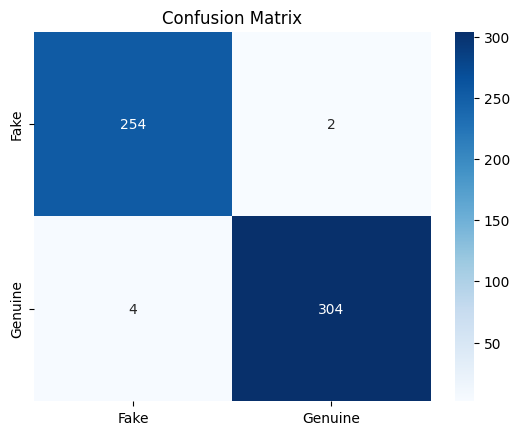

In [205]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Fake", "Genuine"],
                yticklabels=["Fake", "Genuine"])
plt.title("Confusion Matrix")
plt.show()

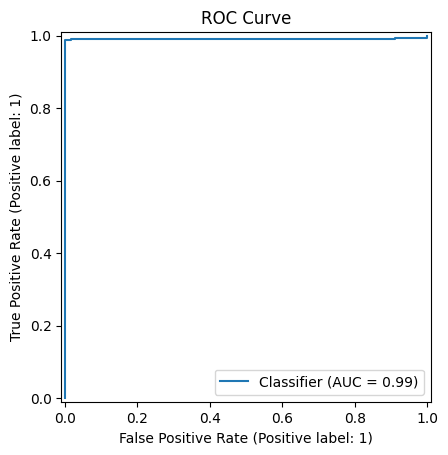

In [207]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

In [209]:
evaluate_model("Logistic Regression",LogisticRegression(),x_train_scaled, x_test_scaled, y_train, y_test)

[0.09504576 0.02790078 0.99894964 0.99851692 0.99731876 0.9975188
 0.99819401 0.08454761 0.08462262 0.03295419 0.99999874 0.08689455
 0.02942079 0.99666721 0.99713983 0.99974771 0.99820401 0.05835003
 0.99965053 0.99977001 0.99996185 0.02711432 0.99800315 0.03438096
 0.04958206 0.57284624 0.99948683 0.09633204 0.99902966 0.03016036
 0.99496045 0.12797465 0.03415945 0.99686503 0.99779588 0.99525165
 0.04662786 0.99693073 0.05311108 0.99592461 0.99833406 0.0483045
 0.99999995 0.04483981 0.14397213 0.16959264 0.99959959 0.08777864
 1.         0.05631007 0.02674968 0.9999757  0.05918189 0.99678682
 0.05146441 0.08233151 0.99425673 0.08750385 0.0610576  0.99494488
 0.05562492 0.9976378  0.05668837 0.04977054 0.99742399 0.99451581
 0.0462075  0.08701922 0.99943315 0.08430915 0.05513416 0.99715166
 0.06870868 0.99884377 0.05571479 0.99996341 0.99785452 0.08557856
 0.99757396 0.99922767 0.0333817  0.02840678 0.99997665 1.
 0.04013599 0.99995928 0.99999999 0.03784915 0.99999998 0.0392725
 0.573

(array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

In [210]:
evaluate_model("KNN",KNeighborsClassifier(),x_train, x_test, y_train, y_test)

[0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.6 1.  1.  1.  0.
 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.
 0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  1.
 0.  0.  1.  0.2 0.  1.  0.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  0.4
 0.  1.  0.  1.  1.  0.  1.  0.6 0.  0.  1.  1.  0.  1.  1.  0.  1.  0.
 1.  0.  1.  1.  0.8 0.  0.  0.4 1.  0.  1.  1.  0.  1.  1.  0.  0.  0.
 0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.6 0.  0.  0.2 0.
 0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
 1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  0.8 1.
 0.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.
 1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.
 0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  1.
 0.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.
 0.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.

(array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [211]:
evaluate_model("Decision Tree",DecisionTreeClassifier(),x_train, x_test, y_train, y_test)

[0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.

(array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [212]:
evaluate_model("Support Vector Machine",SVC(),x_train, x_test, y_train, y_test)

(array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 

In [213]:
evaluate_model("Naive Bayes",GaussianNB(),x_train, x_test, y_train, y_test)

[2.34382656e-11 1.37180744e-11 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 2.44345355e-10
 8.88325259e-11 7.37813432e-12 1.00000000e+00 1.58592535e-10
 2.19751940e-11 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 8.19996870e-12 1.00000000e+00 1.00000000e+00
 1.00000000e+00 2.55259817e-11 1.00000000e+00 8.56738448e-12
 7.10601219e-12 1.00000000e+00 1.00000000e+00 3.25442627e-11
 1.00000000e+00 8.56993638e-12 1.00000000e+00 4.18533133e-10
 1.31185464e-11 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.43215911e-12 1.00000000e+00 7.87896916e-12 1.00000000e+00
 1.00000000e+00 6.96667360e-12 1.00000000e+00 9.57256916e-12
 6.28272412e-10 1.00000000e+00 1.00000000e+00 1.64643473e-10
 1.00000000e+00 8.04441891e-12 8.13927566e-11 1.00000000e+00
 2.37044799e-11 1.00000000e+00 7.42145208e-12 1.28654214e-10
 1.00000000e+00 9.97965798e-01 2.18531972e-11 1.00000000e+00
 7.30839783e-12 1.00000000e+00 9.81023486e-12 6.66905245e-12
 1.00000000e+00 1.000000

(array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [214]:
def random_forest_with_gridsearch(X_train_scaled, X_test_scaled, y_train, y_test):

    params = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    }

    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        params,
        scoring="accuracy",
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train_scaled, y_train)

    print("\nBest Random Forest Parameters:", grid.best_params_)
    best_rf = grid.best_estimator_

    evaluate_model("Random Forest (GridSearchCV)",
                   best_rf, X_train_scaled, X_test_scaled, y_train, y_test)

In [219]:
if __name__ == "__main__":

    # Load data
    genuine, fake, df = read_datasets()

    # Exploratory Data Analysis
    print("\n=== Dataset Head ===")
    print(df.head())

    print("\n=== Summary ===")
    print(df.describe())

    print("\n=== Class Distribution ===")
    print(df["label"].value_counts())

    # Feature engineering
    X, y = extract_features(df)

    # Preprocessing
    X_full, x_train, x_test, x_train_scaled, x_test_scaled, y_train, y_test = preprocess(X, y)




=== Dataset Head ===
        id              name screen_name  statuses_count  followers_count  \
0  3610511  Davide Dellacasa      braddd           20370             5470   
1  5656162    Simone Economo       eKoeS            3131              506   
2  5682702            tacone     tacone_            4024              264   
3  6067292          alesaura    alesstar           40586              640   
4  6015122            Angelo  PerDiletto            2016               62   

   friends_count  favourites_count  listed_count  \
0           2385               145            52   
1            381                 9            40   
2             87               323            16   
3            622              1118            32   
4             64                13             0   

                       created_at                                url  ...  \
0  Fri Apr 06 10:58:22 +0000 2007           http://braddd.tumblr.com  ...   
1  Mon Apr 30 15:08:42 +0000 2007         http:/

In [215]:
random_forest_with_gridsearch(x_train_scaled, x_test_scaled, y_train, y_test)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
[0.   0.   1.   1.   1.   1.   1.   0.   0.02 0.   1.   0.   0.   0.96
 1.   1.   1.   0.   1.   1.   1.   0.   1.   0.   0.   0.97 1.   0.
 1.   0.   0.96 0.   0.   1.   1.   0.99 0.   0.99 0.   1.   1.   0.
 1.   0.   0.   1.   0.99 0.   1.   0.   0.   1.   0.   1.   0.   0.01
 1.   0.94 0.   0.99 0.   1.   0.   0.   1.   1.   0.   0.   1.   0.
 0.   0.98 0.   1.   0.   1.   1.   0.   0.97 0.99 0.   0.   1.   0.96
 0.   0.91 1.   0.   1.   0.   0.98 0.   1.   1.   1.   0.01 0.   0.98
 1.   0.   1.   0.99 0.33 1.   1.   0.01 0.   0.   0.   1.   0.   0.
 1.   1.   1.   1.   0.   1.   0.   0.97 0.   1.   0.   0.   0.93 0.
 0.05 0.14 1.   0.   0.   1.   1.   1.   1.   1.   0.95 1.   0.   0.98
 1.   1.   1.   1.   1.   1.   0.01 1.   1.   0.   0.   0.   0.96 1.
 1.   0.15 1.   1.   1.   1.   0.88 1.   0.   1.   1.   0.   1.   0.
 1.   1.   1.   1.   1.   0.02 0.95 0.99 0